# EPRL vertex renormalization

Notebook for the analysis of EPRL vertex renormalization

## Setup

In [1]:
using JupyterFormatter
using DataFrames, CSV, HalfIntegers, JLD2, Distributions, Random

In [2]:
using Statistics
using StatsBase
using StatsPlots
using LaTeXStrings

In [3]:
pgfplotsx()
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    grid = :true,
    gridlinewidth = 0.5,
    fontfamily="Computer Modern",
    framestyle=:box,
    size=(800,300),
    margin=5Plots.mm
)
scalefontsizes(1.7)

# MC Estimate with $ N_{mc} = 100\,000$

In [53]:
BASE_DATA_DIRECTORY = "../../data";

function get_data(Dl,mu,trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_100000/EPRL/immirzi_0.1/Dl_$(Dl)/weight_$(mu)/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data (generic function with 1 method)

In [54]:
function get_VR_amplitudes(Dl,mu)

layers_trials = DataFrame()

for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(Dl,mu,trial).amp[id] - get_data(Dl,mu,trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

return amplitude_Nmc100K, error_Nmc100K
    
end

get_VR_amplitudes (generic function with 1 method)

plot1 = Plot{Plots.PGFPlotsXBackend() n=1}


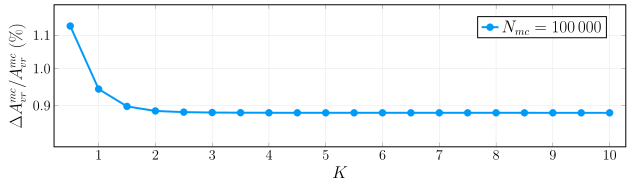

In [70]:
amplitude_Nmc100K, error_Nmc100K = get_VR_amplitudes(10,1.0)
relative_error_Nmc100K_Dl_10 = zeros(20)
relative_error_Nmc100K_Dl_10 .= error_Nmc100K[:] ./ amplitude_Nmc100K[:]

plot1 = plot(0.5:0.5:10,
               [100*relative_error_Nmc100K_Dl_10],
               label = [L"$N_{mc}=100\,000$"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               size = (900, 300),
               ylim = (0.80,1.2),
               yticks = [0.9, 1, 1.1],
               ylabel = L"\Delta A_{vr}^{mc}/A_{vr}^{mc} \ (\%)",
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               legend_column = -1,
               legend = (0.74, 0.92),
               legendfontsize=16,
               yguidefontsize=16,
               xguidefontsize=16,
               )
savefig(plot1,"./plots/EPRL/vertex_renormalization/VR_EPRL_relative_errors.svg")

@show plot1

## Extrapolation

In [60]:
function extrapolate(dataDl, dataDlm1, dataDlm2)
    dataDl - (dataDl - dataDlm1)^2/(dataDl - 2*dataDlm1 + dataDlm2);
end

extrapolate (generic function with 1 method)

In [61]:
function make_lambda(data)
    (data[3:end] .- data[2:end-1]) ./ (data[2:end-1] .- data[1:end-2])
end

make_lambda (generic function with 1 method)

In [62]:
mu = 1.0

ampls_Dl = zeros(21,11)
errors_Dl = zeros(21,11) 

for Dl = 0:10

    ampls_Dl[1] = 0.0
    errors_Dl[1] = 0.0
    
    amplitude_Nmc100K_Dl, error_Nmc100K_Dl = get_VR_amplitudes(Dl,mu)

    ampls_Dl[2:end,Dl+1] .= 10^(17) .* amplitude_Nmc100K_Dl[:]
    errors_Dl[2:end, Dl+1] .= 10^(17) .* error_Nmc100K_Dl[:]
    
end

ampl_extrap = zeros(21)
ampl_extrap[1] = 0.0
ampl_extrap[2:end] .= extrapolate.(ampls_Dl[2:end,end],ampls_Dl[2:end,end-1],ampls_Dl[2:end,end-2]);

lambda10 = zeros(8)
lambda7 = zeros(8)
lambda4 = zeros(8)

lambda10 = make_lambda(ampls_Dl[21,:]);
lambda7 = make_lambda(ampls_Dl[15,:]);
lambda4 = make_lambda(ampls_Dl[9,:]);

plot1 = Plot{Plots.PGFPlotsXBackend() n=4}


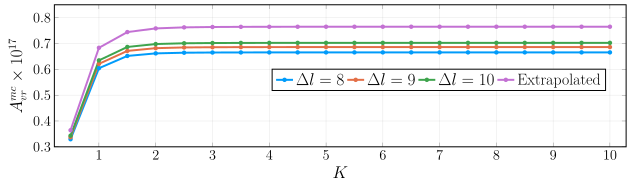

In [69]:
plot1 = plot(0.5:0.5:10,
    [#ampls_Dl[:, 1], ampls_Dl[:, 2], ampls_Dl[:, 3], ampls_Dl[:, 4], ampls_Dl[:, 5], ampls_Dl[:, 6], ampls_Dl[:, 7], ampls_Dl[:, 8],
        ampls_Dl[2:end, 9], ampls_Dl[2:end, 10], ampls_Dl[2:end, 11], ampl_extrap[2:end]],
               label = [#L"\Delta l=0" L"\Delta l=1" L"\Delta l=2" L"\Delta l=3" L"\Delta l=4" L"\Delta l=5" L"\Delta l=6" L"\Delta l=7" 
        L"\Delta l=8" L"\Delta l=9" L"\Delta l=10" L"\textrm{Extrapolated}"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               size = (900, 300),
               ylim = (0.3,0.85),
               #yticks = [0, 0.4, 0.8],
               ylabel = L"A_{vr}^{mc} \times 10^{17}",
               xlabel = L"K",
               #yerror = [errors_Dl[:, 1], errors_Dl[:, 2], errors_Dl[:, 3], errors_Dl[:, 4], errors_Dl[:, 5], 
               #          errors_Dl[:, 6], errors_Dl[:, 7], errors_Dl[:, 8], errors_Dl[:, 9], errors_Dl[:, 10], errors_Dl[:, 11]],
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 3,
               legend_column = -1,
               legend = (0.38, 0.55),
               legendfontsize=16,
               yguidefontsize=16,
               xguidefontsize=16,
               )

savefig(plot1,"./plots/EPRL/vertex_renormalization/VR_EPRL_final_Dl_extrap_mu_$(mu).svg")

@show plot1

plot2 = Plot{Plots.PGFPlotsXBackend() n=3}


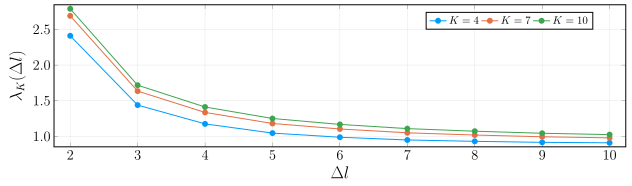

In [55]:
plot2 = plot(
    2:10,
    [   
        lambda4,
        lambda7,
        lambda10,
    ],
    label = [ L"K=4" L"K=7" L"K=10"],
    xlabel = L"\Delta l",
    ylabel = L"\lambda_K(\Delta l)",
    markershape = [:circle :circle :circle],
    shape = [:circle :circle :circle],
    xticks = 2:10,
    #ylim = (0.6, 1.3),
    size = (900, 300),
    legend = (0.65, 0.95),
    legend_column = -1,
    legendfontsize=11,
    yguidefontsize=16,
    xguidefontsize=16,
)

savefig(plot2,"./plots/EPRL/vertex_renormalization/VR_lambda_K_mu_$(mu).svg")

@show plot2

In [50]:
function make_lambda(data)
    (data[3:end] .- data[2:end-1]) ./ (data[2:end-1] .- data[1:end-2])
end

make_lambda (generic function with 1 method)

In [11]:
function get_spins_configs(K)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/spins_configurations/spins_configurations_cutoff_$(K).0.csv",
        ),
    )
end

get_spins_configs (generic function with 1 method)

In [85]:
spins_conf = collect(get_spins_configs(10)[:,1]);

cutoffs_long = collect(0.5:0.5:10);

In [118]:
using LsqFit
linmod(x, p) = @.x*0.0 + p[1]

fit_VR = curve_fit(linmod, cutoffs_long[10:end], ampl_extrap[11:end], [2.0])
fit_VR.param

1-element Vector{Float64}:
 0.7649584217911347

In [119]:
margin_error(fit_VR, 0.05)

1-element Vector{Float64}:
 1.4627019859550901e-5

plot1 = Plot{Plots.PGFPlotsXBackend() n=2}


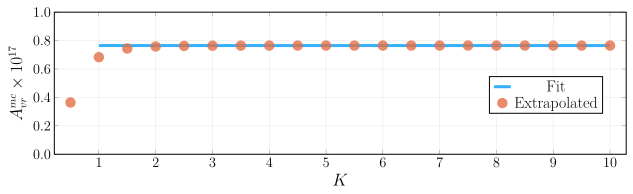

In [121]:
plot1 = plot(cutoffs_long[2:end], linmod(ampl_extrap[3:end], fit_VR.param), 
               opacity = 0.8,
               legendfontsize=16,
               label = ["Fit"],
               yguidefontsize=16,
               xguidefontsize=16,
               markerstrokewidth = 1.5,
               linewidth=3,
               markersize = 5,
               ylim = (0, 1),
               titlefontsize = 15,
               yticks = [0, 0.2, 0.4, 0.6, 0.8, 1], 
               xticks = 1:10, #(10 .^ collect(1:10)),
               size = (900, 300),)

scatter!(cutoffs_long, ampl_extrap[2:end], opacity = 0.8, label = ["Extrapolated"], legend = (0.76, 0.55), markersize = 7)

#xticks!([1,2,5,10], string.([1,2,5,10]))
#yticks!(10 .^ collect(0:8))
xlabel!(L"K")
ylabel!(L"A_{vr}^{mc} \times 10^{17}")

savefig(plot1,"./plots/EPRL/vertex_renormalization/VR_EPRL_Scaling_fit.svg")
#savefig(plot1,"./plots/BF/self_energy/relative_errors.pdf")

@show plot1